In [7]:
library(rugarch)
library(VineCopula)
library(fGarch) 
library(quantreg)
library(readxl)
library(xts)

In [82]:
#用相对路径读取数据更整洁，代码鲁棒性更强
df <- read_excel("./test.xlsx")
df$日期 <- as.Date(df$日期, format = "%Y-%m-%d")
# 调整为日期格式
ts_df <- xts(df[-1], order.by = df$日期)
date_st <- index(ts_df)
dim(ts_df)
tail(ts_df)

[1] 1678   39

           香蜜湖指数   中国银行   工商银行   交通银行   建设银行   中信银行
2024-04-16 -4.0291639  1.0834342  0.9182801  0.2989539  0.4192878 -1.5015297
2024-04-17  4.2765524  0.4301082  0.5469476  0.8915364  1.5225208  9.5172638
2024-04-18 -0.3160644  0.6417134  0.3629768  1.3225762  0.2743486  8.6896744
2024-04-19 -1.6792034  0.6376217  0.5420067  0.7272759  0.6825965 -8.6896744
2024-04-22  0.3443545 -1.2793351 -1.2692827 -0.8733680 -0.6825965 -3.4993074
2024-04-23  0.5518959  0.0000000  0.3642991  1.1628038  0.1368926  0.2844952
              平安银行   浦发银行    招商银行   华夏银行    中信证券   海通证券
2024-04-16 -0.09722898 -0.5494519 -0.24397694 -0.3007521 -0.62199805 -1.6571444
2024-04-17  3.25387558  1.0959014  1.66544349  1.9389123  2.63099419  1.9096697
2024-04-18  1.68071183 -0.1363327  1.04556591  0.8823587  0.60589555  1.6260521
2024-04-19 -1.02374091  0.1363327 -0.08919281  0.2923979 -0.44028690 -0.2484473
2024-04-22 -1.79334679 -0.6835297 -0.83632507 -0.5856532  0.82395413  0.6199648
2024-04-23  0.38022859  0.6835

In [5]:
#ARMA egarch model
uspec <- ugarchspec(mean.model = list(armaOrder = c(1,2), include.mean = TRUE),
variance.model = list(model = "eGARCH"), 
distribution.model = "sstd")
#用刚刚定义的模型拟合各列数据
f1 <- function(x) {ugarchfit(uspec, data = x)}
fit <- apply(ts_df,2, f1)

In [9]:
# 保存ugarchfit对象，这样就不用重复跑了
saveRDS(fit, file = "garch_model.rds")
#读取模型
fit <- readRDS(file = "garch_model.rds")

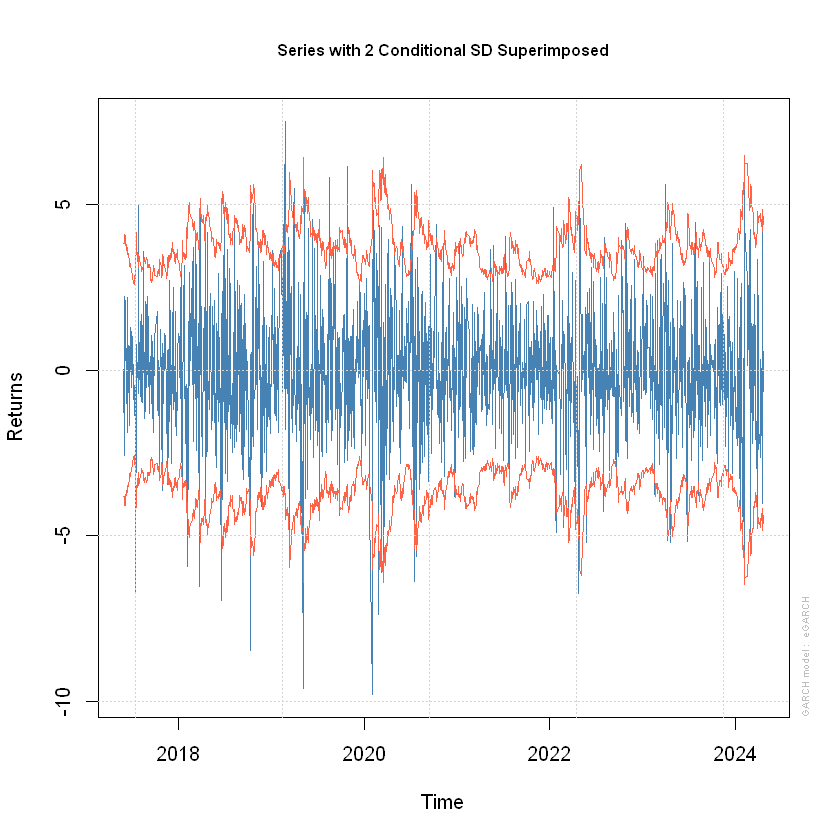

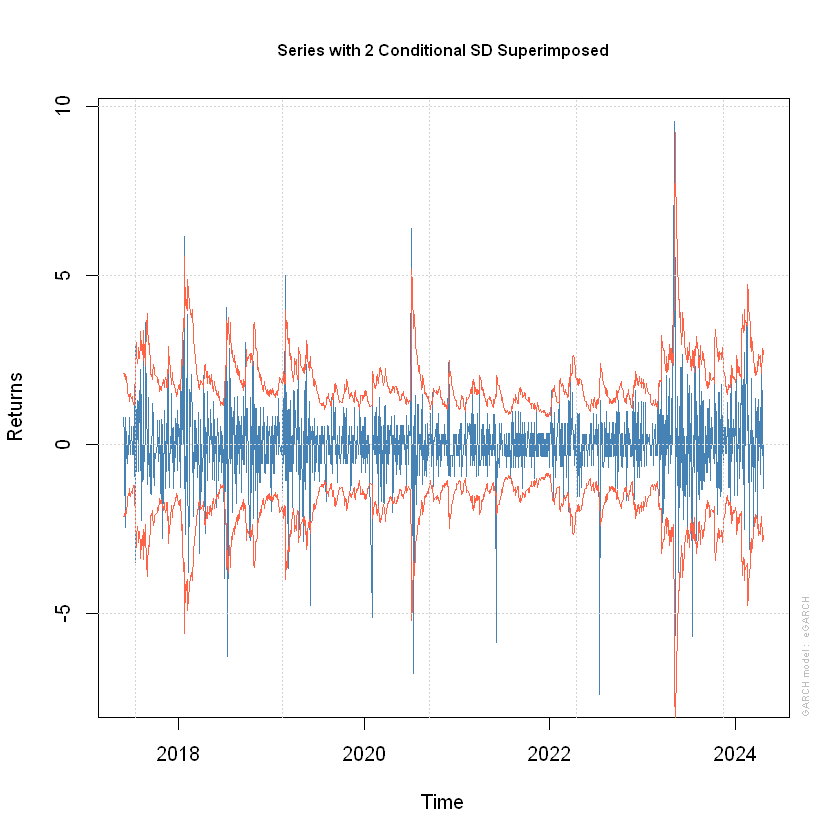

In [10]:
#绘图（先以香蜜湖指数和中国银行为例）
plot(fit$香蜜湖指数,which=1)
plot(fit$中国银行,which=1)

In [83]:
fintech_res <- residuals(fit$香蜜湖指数)
index(fintech_res) <- date_st
cbank_res <- residuals(fit$中国银行)
index(cbank_res) <- date_st

In [15]:
##process of Returns of the 中国银行
## <-记得加空格，代码规范
spec_cbank <- uspec
setfixed(spec_cbank) <- as.list(coef(fit$中国银行))

filt_cbank <- ugarchfilter(spec_cbank, ts_df$中国银行)

In [33]:
length(cbank_res) == length(sigma(filt_cbank))

[1] TRUE

In [88]:
rrss <- cbind(cbank_res,sigma(filt_cbank),cbank_res/sigma(filt_cbank))
ssss1 <- cbind(ts_df$中国银行,fitted(filt_cbank), cbank_res, sigma(filt_cbank), cbank_res/sigma(filt_cbank))
rrss

              cbank_res sigma.filt_cbank. cbank_res.sigma.filt_cbank.
2017-05-31  0.781207783         1.0622322                 0.735439751
2017-06-01  0.296540432         1.0622322                 0.279167241
2017-06-02 -0.517333456         1.0273607                -0.503555827
2017-06-05 -2.483256010         0.9781527                -2.538720275
2017-06-06  0.080472291         1.0376214                 0.077554579
2017-06-07  0.728604319         0.9734941                 0.748442442
2017-06-08 -0.029845882         1.0149065                -0.029407518
2017-06-09 -0.322765406         0.9429291                -0.342300830
2017-06-12 -0.615227674         0.8925004                -0.689330454
2017-06-13 -0.094366289         0.8616862                -0.109513525
       ...                                                           
2024-04-10  0.199923316         1.2532304                 0.159526380
2024-04-11 -0.434070872         1.1840365                -0.366602620
2024-04-12  0.191142

In [49]:
##process of Returns of the 香蜜湖指数
spec_fintech = uspec
setfixed(spec_fintech)<-as.list(coef(fit$香蜜湖指数))
filt_fintech = ugarchfilter(spec_fintech, ts_df$香蜜湖指数)
rrss1<-cbind(fintech_res,sigma(filt_fintech),fintech_res/sigma(filt_fintech))
ssss2<-cbind(ts_df$香蜜湖指数,fitted(filt_fintech),fintech_res,sigma(filt_fintech),fintech_res/sigma(filt_fintech))

aaaa<-cbind(fintech_res/sigma(filt_fintech),cbank_res/sigma(filt_cbank))

In [53]:
write.csv(aaaa, "E:\\硕士毕业论文\\Rcode\\cbank_residuals.csv")
ts_df_1<-read.csv('E:\\硕士毕业论文\\Rcode\\cbank_residuals.csv')

In [54]:
##input the redusuals of returns
dim(ts_df_1)
tail(ts_df_1)
tail(aaaa)

[1] 1324    3

,X,e1,e1.1
,<int>,<lgl>,<dbl>
1319,1319,NA,0.16143234
1320,1320,NA,1.15567853
1321,1321,NA,0.42000623
1322,1322,NA,0.52869878
1323,1323,NA,0.54664521
1324,1324,NA,-0.00129617


           e1        e1.1
2024-04-11 NA  0.16143234
2024-04-15 NA  1.15567853
2024-04-16 NA  0.42000623
2024-04-17 NA  0.52869878
2024-04-18 NA  0.54664521
2024-04-22 NA -0.00129617

In [95]:
# 检查数据是否存在和非空
if(length(fintech_res) > 0 && length(cbank_res) > 0) {
    aaaa <- cbind(fintech_res / sigma(filt_fintech), cbank_res / sigma(filt_cbank))
    write.csv(aaaa, "E:\\硕士毕业论文\\Rcode\\cbank_residuals.csv")
} else {
    print("Residual data is empty or not calculated properly.")
}


In [55]:
# 创建数据框前打印信息确认
print(head(fintech_res / sigma(filt_fintech)))
print(head(cbank_res / sigma(filt_cbank)))

# 创建数据框
aaaa <- cbind(fintech_res / sigma(filt_fintech), cbank_res / sigma(filt_cbank))

# 检查数据框维度和列名
print(dim(aaaa))
print(colnames(aaaa))


     e1


                    e1
2017-05-31  0.27916686
2017-06-01 -0.48702570
2017-06-05  0.08226949
2017-06-06  0.70218833
2017-06-07 -0.03065757
2017-06-08 -0.31802429
[1] 1324    2
[1] "e1"   "e1.1"
